<a href="https://colab.research.google.com/github/tago893/capstone/blob/main/models/Arima_tested_daily_code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ethereum Predictions with ARIMA

## Contents:
* [Monthly Forecasting](#monthlyForecasting)
    * [Stationarity check and Seasonal decomposition](#StationarityCheck)
    * [Transformation](#Transformation)
    * [Differencing](#Differencing)
        * [Seasonal differentiation](#SeasonalDifferentiation")
        * [Regular differentiation](#RegularDifferentiation")
    * [Autocorrelation](#Autocorrelation")
    * [ARIMAModel](#ARIMAModel")
        * [Analysis of Results](#AnalysisARIMA")
        * [PredictionARIMA](#PredictionARIMA")

In [44]:
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats

In [46]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [47]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 

# download dataframe
data = pdr.get_data_yahoo("ETH-USD")

[*********************100%***********************]  1 of 1 completed


In [48]:
data

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-11-09   308.644989   329.451996   307.056000   320.884003   320.884003   
2017-11-10   320.670990   324.717987   294.541992   299.252991   299.252991   
2017-11-11   298.585999   319.453003   298.191986   314.681000   314.681000   
2017-11-12   314.690002   319.153015   298.513000   307.907990   307.907990   
2017-11-13   307.024994   328.415009   307.024994   316.716003   316.716003   
...                 ...          ...          ...          ...          ...   
2023-02-28  1634.502441  1644.435791  1602.428101  1605.895142  1605.895142   
2023-03-01  1606.040405  1663.433716  1601.548584  1663.433716  1663.433716   
2023-03-02  1663.549072  1672.051147  1622.599976  1647.319336  1647.319336   
2023-03-03  1647.557739  1648.475342  1552.451538  1569.167603  1569.167603   
2023-03-04  1569.558594  1575.361938  1566.522339  1569.268066  1569.268066   

                Volume  
Date                    
2017-11-09   893249984  
2017-11-10   885985984  
2017-11-11   842300992  
2017-11-12  1613479936  
2017-11-13  1041889984  
...                ...  
2023-02-28  6323676957  
2023-03-01  7701847224  
2023-03-02  7080950926  
2023-03-03  9922240199  
2023-03-04  6020410880  

[1942 rows x 6 columns]

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1942 entries, 2017-11-09 to 2023-03-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1942 non-null   float64
 1   High       1942 non-null   float64
 2   Low        1942 non-null   float64
 3   Close      1942 non-null   float64
 4   Adj Close  1942 non-null   float64
 5   Volume     1942 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 106.2 KB


In [50]:
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Visualization


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

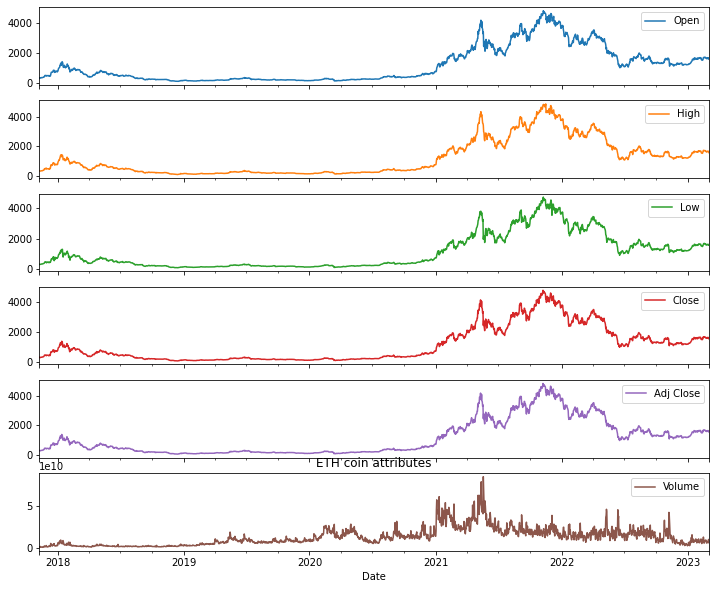

In [52]:
selected_columns = ['Open', 'High', 'Low', 'Close','Adj Close','Volume']
data[selected_columns].plot(subplots=True, figsize=(12,10))
plt.title('ETH coin attributes')
plt.show()

In [53]:
df2=pdr.get_data_yahoo("ETH-USD",)
del df2["Adj Close"]


[*********************100%***********************]  1 of 1 completed


In [54]:
df2.describe()

Open         High          Low        Close        Volume
count  1942.000000  1942.000000  1942.000000  1942.000000  1.942000e+03
mean   1142.991962  1179.112811  1102.186795  1143.408403  1.272815e+10
std    1171.672557  1207.257168  1130.554815  1171.091039  1.066248e+10
min      84.279694    85.342743    82.829887    84.308296  6.217330e+08
25%     214.323799   220.246418   208.710354   214.295589  4.558415e+09
50%     560.891113   581.254242   540.786835   563.559998  1.031033e+10
75%    1715.794861  1759.398468  1672.195099  1715.812286  1.797717e+10
max    4810.071289  4891.704590  4718.039062  4812.087402  8.448291e+10

# Monthly Forecasting <a name="monthlyForecasting"></a>

This plot helps us visualize the max and min values of monthly helping us
infering that:

1. 30th november 2021 has the high maximum price and 31st december 2018 has high minimum price compared to other years
2. From year 2019 to 2020 the maximum and minimum closing prices of Ethereum closing price are near.

In [55]:
df2_month=df2.resample(rule="MS").mean()

In [56]:
df2_month

Open         High          Low        Close        Volume
Date                                                                        
2017-11-01   373.696317   393.111908   363.283635   379.732093  1.225341e+09
2017-12-01   630.583997   667.252580   596.163133   640.209291  2.576202e+09
2018-01-01  1093.099893  1163.799714  1024.934606  1103.646004  5.277749e+09
2018-02-01   882.527006   917.850394   825.723679   873.116318  2.978337e+09
2018-03-01   640.787129   653.875259   606.506935   625.761325  1.732780e+09
...                 ...          ...          ...          ...           ...
2022-11-01  1307.122107  1341.226990  1262.868237  1297.930184  1.405993e+10
2022-12-01  1240.294394  1255.038866  1221.342147  1237.105890  5.197763e+09
2023-01-01  1454.913763  1486.601736  1434.767791  1466.950026  7.256547e+09
2023-02-01  1623.919765  1654.276873  1595.175406  1624.605630  7.991048e+09
2023-03-01  1621.676453  1639.830536  1585.780609  1612.297180  7.681362e+09

[65 rows x 5 columns]

<AxesSubplot:xlabel='Date'>

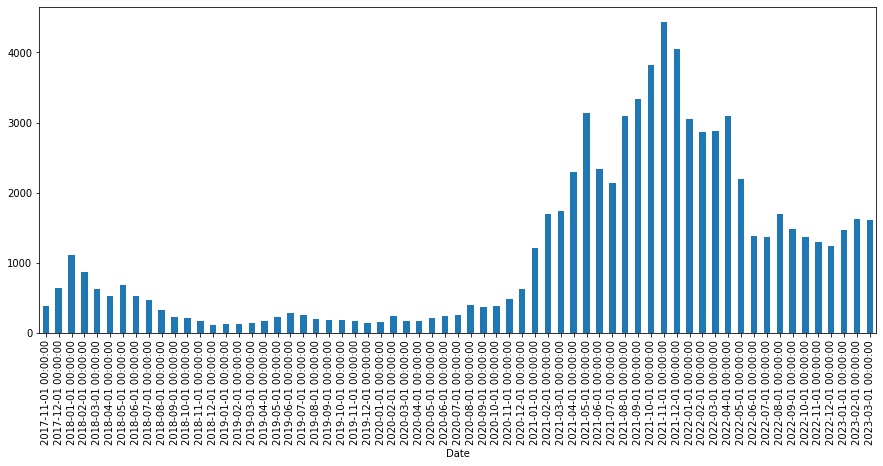

In [57]:
df2['Close'].resample(rule='MS').mean().plot(kind="bar",figsize=(15,6))

# Stationarity check and seasonal decomposition<a name="StationarityCheck"></a>

##Stationarity check

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

In [58]:
import statsmodels.api as sm

<Figure size 2160x720 with 0 Axes>

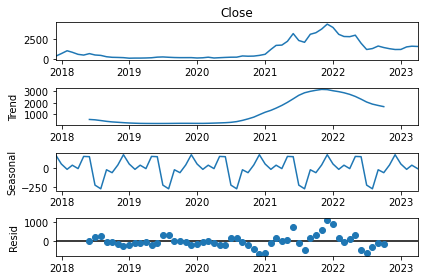

In [101]:
plt.figure(figsize=[30,10])
sm.tsa.seasonal_decompose(df2.resample(rule='M').median().Close).plot()
plt.show()

In [60]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adf_test(data['Close'])

ADF Statistics: -1.4188319585576936
p- value: 0.5732152873706245
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [62]:
df2_daily = df2.resample('D').mean()
df2_daily

Open         High          Low        Close        Volume
Date                                                                        
2017-11-09   308.644989   329.451996   307.056000   320.884003  8.932500e+08
2017-11-10   320.670990   324.717987   294.541992   299.252991  8.859860e+08
2017-11-11   298.585999   319.453003   298.191986   314.681000  8.423010e+08
2017-11-12   314.690002   319.153015   298.513000   307.907990  1.613480e+09
2017-11-13   307.024994   328.415009   307.024994   316.716003  1.041890e+09
...                 ...          ...          ...          ...           ...
2023-02-28  1634.502441  1644.435791  1602.428101  1605.895142  6.323677e+09
2023-03-01  1606.040405  1663.433716  1601.548584  1663.433716  7.701847e+09
2023-03-02  1663.549072  1672.051147  1622.599976  1647.319336  7.080951e+09
2023-03-03  1647.557739  1648.475342  1552.451538  1569.167603  9.922240e+09
2023-03-04  1569.558594  1575.361938  1566.522339  1569.268066  6.020411e+09

[1942 rows x 5 columns]

#Feature Engineering

## Box-Cox Transformation <a name="Transformation"></a>

Lets use the Box-Cox transformation to suppress some of the variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated.

In [63]:
# Box-Cox Transformations
df2_daily['close_box'], lmbda = stats.boxcox(df2_daily.Close)
print("Dickey–Fuller test: p=%f" % adfuller(df2_daily.close_box)[1])

Dickey–Fuller test: p=0.778761


:The p-value indicates that series is still not stationary.


## Seasonal decomposition

Dickey–Fuller test: p=0.573215


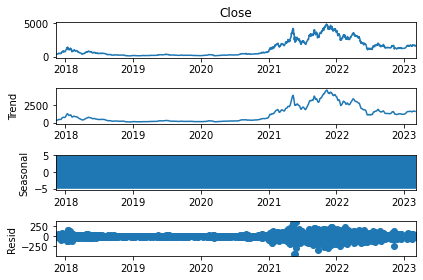

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df2.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(data.Close)[1])
plt.show()

The p-value indicates that series is still not stationary.


## Differencing <a name="Differencing"></a>

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary. 


In [64]:
# Seasonal differentiation (12 months)
df2_daily['box_diff_seasonal_12'] = df2_daily.close_box - df2_daily.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(df2_daily.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.000000


The p-value indicates that series is still not stationary.


Dickey–Fuller test: p=0.000000


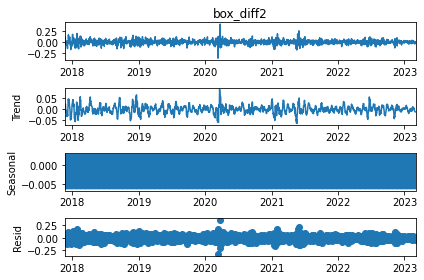

In [65]:
# Regular differentiation
df2_daily['box_diff2'] = df2_daily.box_diff_seasonal_12 - df2_daily.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(df2_daily.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(df2_daily.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary.


In [66]:
df2_daily.Close

Date
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
2017-11-13     316.716003
                 ...     
2023-02-28    1605.895142
2023-03-01    1663.433716
2023-03-02    1647.319336
2023-03-03    1569.167603
2023-03-04    1569.268066
Freq: D, Name: Close, Length: 1942, dtype: float64

## Autocorrelation  <a name="Autocorrelation"></a>

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals. 



Lets try out autocorrelation on the differences...

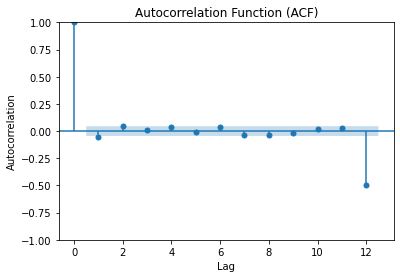

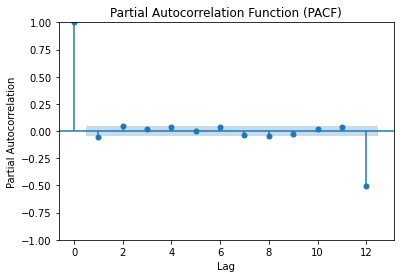

In [67]:

sm.graphics.tsa.plot_acf(df2_daily.box_diff2[13:], lags=12)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF)")
plt.show()
sm.graphics.tsa.plot_pacf(df2_daily.box_diff2[13:], lags=12)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models. 

# ARIMA Model  <a name="ARIMAModel"/>
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

     

1.  p - the number of lag observations to include in the model, or lag order.(AR)
2.  d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
3.  q - the size of the moving average window, also called the order of moving average.(MA)


A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.
A value of 0 for a parameter indicates to not use that element of the model. 

## Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [118]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')
#Split data into training and testing sets
train_data, test_data = df2_daily['close_box'][:'2021-08-01'], df2_daily['close_box']['2021-08-02':]
# Initial approximation of parameters
model = ARIMA(df2_daily.close_box, order=(1, 1, 0))
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                 1942
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3896.599
Date:                Sat, 04 Mar 2023   AIC                          -7789.198
Time:                        12:03:50   BIC                          -7778.056
Sample:                    11-09-2017   HQIC                         -7785.101
                         - 03-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0463      0.016     -2.907      0.004      -0.078      -0.015
sigma2         0.0011   1.25e-05     84.317      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

## Analysis of Results  <a name="AnalysisARIMA"></a>



##Prediction


In [119]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

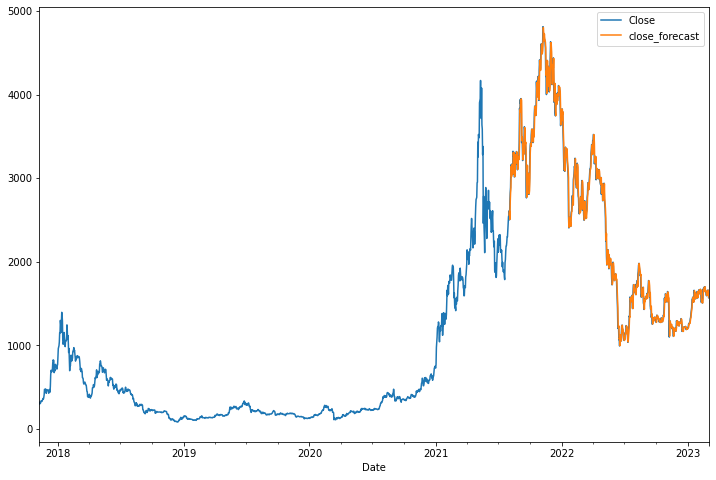

In [120]:
# inverse Box-Cox transformation and plot predicted values
df2_daily['close_box_diff_seasonal_12_forecast'] = results.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)
df2_daily['close_forecast'] = invboxcox(df2_daily.close_box_diff_seasonal_12_forecast, lmbda)
df2_daily[['Close', 'close_forecast']].plot(figsize=(12, 8))
plt.show()

## Validation <a name="validationSARIMAX"></a>

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets calcualte RMSE for the one-step ahead predictions starting from 2018, through to the end of 2022.


In [121]:
y_forecasted = df2_daily.close_forecast
y_truth = df2_daily['2018-1-31':].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 107.04
